In [1]:
using ModelingToolkit, DifferentialEquations, Plots
using ModelingToolkit: t_nounits as t, D_nounits as D
using Symbolics

In [2]:
mutable struct Wall
    rho::Float64
    V::Float64
    m::Float64
    Cp::Float64
    m_elem::Float64
end
mutable struct Ref
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    Ge1::Float64
    Ge2::Float64
end
mutable struct Fld
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    k::Float64
    Pr::Float64
    rho::Float64
    mu::Float64
    Cp::Float64
    mdot::Float64
    T_in::Float64
end
mutable struct HX_PHX
    N_t::Int64
    N_c::Int64
    N_f::Int64
    L_w::Float64
    L_v::Float64
    A_t::Float64
    phi::Float64
    p::Float64
    t::Float64
    b::Float64
    D_h::Float64
    beta::Float64
    N_CV::Int64
    Wall::Wall
    Ref::Ref
    Fld::Fld
    isCounterFlow::Bool
end

SymHX = Symbolics.symstruct(HX_PHX)
SymWall = Symbolics.symstruct(Wall)
SymRef = Symbolics.symstruct(Ref)
SymFld = Symbolics.symstruct(Fld)

Symbolics.Struct{Fld}

In [3]:
function make_HX(N_t::Int64, L_w::Float64, L_v::Float64, A_t::Float64, p::Float64, t::Float64, N_CV::Int64, isCounterFlow::Bool)
    # DIC-193-33 판형 열교환기. http://www.dibr.co.kr/exchanger/detail/D93RP00056?ts=1735978818&capacity=0.5&cate=162&
    N_t = N_t
    N_c = (N_t - 1) * 2
    N_f = (N_t - 1) * 2
    L_w = L_w
    L_v = L_v
    A_t = A_t
    phi = A_t / (L_w * L_v * (N_t - 2))
    p = p
    t = t
    b = p - t 
    D_h = 2 * b / phi
    beta = 25 * pi / 180
    N_CV = N_CV

    # Wall 관련 물성, 기하
    Wall_rho = 7.93e3 # STS 304 밀도
    Wall_V = A_t * t
    Wall_m = Wall_V * Wall_rho
    Wall_Cp = 502 # 비열

    # Ref, Fld 기하
    Ref_V = N_c * L_w * b* L_v
    Ref_A_cs = N_c * L_w * b
    Fld_V =  N_f * L_w * b * L_v
    Fld_A_cs = N_f * L_w * b

    # Element별 기하
    Wall_m_elem = Wall_m / N_CV
    Ref_V_elem = Ref_V / N_CV
    Ref_A_elem = Ref_A_cs / N_CV
    Fld_V_elem = Fld_V / N_CV
    Fld_A_elem = Ref_A_elem

    # Ref UA 관련 물성
    Ref_Ge1 = 11.22*(b/D_h)^-2.83 * (pi/2 - beta)^-4.5
    Ref_Ge2 = 0.35*(b/D_h)^0.23 * (pi/2 - beta)^1.48

    # Fld 관련 물성(물, 15도, 포화액, refprop 기준)
    Fld_k = 0.5887
    Fld_Pr = 1.7058
    Fld_rho = 999.0561
    Fld_mu = 0.0011
    Fld_Cp = 4.1888e3

    # Fld
    Fld_mdot = 0.1
    Fld_T_in = 273.15 + 40
    isCounterFlow = isCounterFlow

    HX_Wall = Wall(Wall_rho, Wall_V, Wall_m, Wall_Cp, Wall_m_elem)
    HX_Ref = Ref(Ref_V, Ref_A_cs, Ref_V_elem, Ref_A_elem, Ref_Ge1, Ref_Ge2)
    HX_Fld = Fld(Fld_V, Fld_A_cs, Fld_V_elem, Fld_A_elem, Fld_k, Fld_Pr, Fld_rho, Fld_mu, Fld_Cp, Fld_mdot, Fld_T_in)
    return HX_PHX(N_t, N_c, N_f, L_w, L_v, A_t, phi, p, t, b, D_h, beta, N_CV, HX_Wall, HX_Ref, HX_Fld, isCounterFlow)
end
# HX_E 기본 
HX_E_N_t = 33
HX_E_L_w = 0.083
HX_E_L_v = 0.154
HX_E_A_t = 0.434
HX_E_p = 2.35e-3
HX_E_t = 0.4e-3
HX_E_N_CV = 20
HX_E_isCounterFlow = true
HX_E = make_HX(HX_E_N_t, HX_E_L_w, HX_E_L_v, HX_E_A_t, HX_E_p, HX_E_t, HX_E_N_CV, HX_E_isCounterFlow)

# 다른 Component
P_in_val = 3200e3
P_out_val = 3000e3
h_in_val = 450e3
c1_val = 9e-6
c2_val = c1_val


9.0e-6

In [4]:
# Q11. MTK ver
using CoolProp
# CoolProp 함수들을 MTK에 등록합니다. (추후 Tabular 값으로 변경)
 # ρ, T 등을 P, h에서 계산하는 함수
R410a_density(p, h) = PropsSI("Dmass", "P", p, "Hmass", h, "R410A")
R410a_temperature(p, h) = PropsSI("T", "P", p, "Hmass", h, "R410A")

# 건도 0, 1에서 물성 찾기 // 건도 0에서 열물성 계산
R410a_h_L(P) = PropsSI("Hmass", "P", P, "Q", 0, "R410A")
R410a_h_V(P) = PropsSI("Hmass", "P", P, "Q", 1, "R410A")
R410a_rho_L(P) = PropsSI("Dmass", "P", P, "Q", 0, "R410A")
R410a_rho_V(P) = PropsSI("Dmass", "P", P, "Q", 1, "R410A")

R410a_k_L(P) = PropsSI("L", "P", P, "Q", 0, "R410A")
R410a_mu_L(P) = PropsSI("V", "P", P, "Q", 0, "R410A")
R410a_Pr_L(P) = PropsSI("Prandtl", "P", P, "Q", 0, "R410A")

R410a_x(P,h) = (h - R410a_h_L(P)) / (R410a_h_V(P) - R410a_h_L(P))

# Symbolics에 등록
@register_symbolic R410a_density(p, h) 
@register_symbolic R410a_temperature(p, h)

@register_symbolic R410a_h_L(P)
@register_symbolic R410a_h_V(P)
@register_symbolic R410a_rho_L(P)
@register_symbolic R410a_rho_V(P)

@register_symbolic R410a_k_L(P)
@register_symbolic R410a_mu_L(P)
@register_symbolic R410a_Pr_L(P)

@register_symbolic R410a_x(P, h)

# Symbolics에 사용할 미분 연산 정의
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{1}) = R410a_density(args[1]+1, args[2]) -  R410a_density(args[1], args[2])
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{2}) = R410a_density(args[1], args[2]+1) -  R410a_density(args[1], args[2])

In [ ]:
# UA_elem의 연산 함수 등록
function U_func(P, h, mdot_in, HX_D_h, HX_beta, HX_Ref_A_cs, HX_Ref_Ge1, HX_Ref_Ge2)
    x = R410a_x(P, h)
    ref_k_L = R410a_k_L(P)
    ref_mu_L = R410a_mu_L(P)
    ref_Pr_L = R410a_Pr_L(P)
    ref_rho_L = R410a_rho_L(P)
    ref_rho_V = R410a_rho_V(P)
    
    G = mdot_in / HX_Ref_A_cs
    Re_L = max(0, G * HX_D_h / ref_mu_L)
    U_ref_single = 0.295 * (ref_k_L/HX_D_h) * Re_L^0.64 * ref_Pr_L^0.32 * (π/2 - HX_beta)^0.09

    G_eq_tp = G * (1-x + x*(ref_rho_L/ref_rho_V)^0.5)
    Re_eq_tp = max(0, G_eq_tp * HX_D_h / ref_mu_L)
    U_ref_tp = HX_Ref_Ge1 * (ref_k_L/HX_D_h) * Re_eq_tp^HX_Ref_Ge2 * ref_Pr_L^(1/3)
   
    # 기울기 계산
    slope1 = (U_ref_tp - U_ref_single) / 0.1
    slope2 = (U_ref_single - U_ref_tp) / 0.1 # slope2는 -slope1과 같음

    # 각 구간의 기울기 변화를 더하여 최종값을 계산
    U_ref = U_ref_single + 
            slope1 * max(0, x - 0.0) +      # x=0에서 기울기 0 -> slope1로 증가
            -slope1 * max(0, x - 0.1) +     # x=0.1에서 기울기 slope1 -> 0으로 감소
            slope2 * max(0, x - 0.9) +      # x=0.9에서 기울기 0 -> slope2로 증가
            -slope2 * max(0, x - 1.0)       # x=1.0에서 기울기 slope2 -> 0으로 감소
    return U_ref
end

U_func (generic function with 6561 methods)

In [6]:
@register_symbolic U_func(P, h, mdot_in, HX_D_h, HX_beta, HX_Ref_A_cs, HX_Ref_Ge1, HX_Ref_Ge2)

In [5]:
function U_func_Fld(mdot_Fld, HX_D_h, HX_beta, HX_Fld_A_cs, k_Fld, mu_Fld, Pr_Fld)
    G = mdot_Fld / HX_Fld_A_cs
    Re_Fld = G * HX_D_h / mu_Fld
    U_ref_Fld = 0.295 * (k_Fld/HX_D_h) * Re_Fld^0.64 * Pr_Fld^0.32 * (π/2 - HX_beta)^0.09
    return U_ref_Fld
end

U_func_Fld (generic function with 1 method)

In [7]:
@register_symbolic U_func_Fld(mdot_Fld, HX_D_h, HX_beta, HX_Fld_A_cs, k_Fld, mu_Fld, Pr_Fld)

In [8]:
# 1. Params, Variables for Ref
N = HX_E.N_CV
mdot_Fld = HX_E.Fld.mdot
D_h = HX_E.D_h
beta = HX_E.beta
Fld_A_cs = HX_E.Fld.A_cs
k_Fld = HX_E.Fld.k
mu_Fld = HX_E.Fld.mu
Pr_Fld = HX_E.Fld.Pr
U_Fld_elem = U_func_Fld(mdot_Fld, D_h, beta, Fld_A_cs, k_Fld, mu_Fld, Pr_Fld)

529.7034987518723

In [10]:
@parameters begin
    HX::SymHX = HX_E
    HX_Ref::SymRef = HX_E.Ref
    HX_Fld::SymFld = HX_E.Fld
    HX_Wall::SymWall = HX_E.Wall

    HX_D_h = HX_E.D_h
    HX_beta = HX_E.beta
    HX_isCounterFlow = HX_E.isCounterFlow

    HX_Ref_A_cs = HX_E.Ref.A_cs
    HX_Ref_A_elem = HX_E.Ref.A_elem
    HX_Ref_Ge1 = HX_E.Ref.Ge1
    HX_Ref_Ge2 = HX_E.Ref.Ge2
    HX_Ref_V_elem = HX_E.Ref.V_elem

    HX_mdot_Fld = HX_E.Fld.mdot
    HX_T_Fld_in = HX_E.Fld.T_in
    HX_Fld_A_elem = HX_E.Fld.A_elem
    HX_Fld_Cp = HX_E.Fld.Cp

    UA_Fld_elem = U_Fld_elem * HX_E.Fld.A_elem

    HX_Wall_m_elem = HX_E.Wall.m_elem
    HX_Wall_Cp = HX_E.Wall.Cp
end

@parameters begin
    c1=c1_val 
    c2=c2_val
    P_in=P_in_val 
    P_out=P_out_val 
    h_in=h_in_val 
    ρ_in=R410a_density(P_in, h_in)
end

# 1. Variables for Ref
@variables begin
    P(t)=P_in_val # P_in_val에서 50kPa 감소
    h(t)[1:N]=h_in_val*ones(N) 
    ρ(t)[1:N] 
    T(t)[1:N]
end
@variables begin
    mdot_in(t)[1:N] 
    mdot_out(t)[1:N] 
    Q_r(t)[1:N] 
    h_out(t)[1:N] 
    UA_elem(t)[1:N]
end

# 2. Variables for Wall
@variables T_wall(t)[1:N] = HX_E.Fld.T_in*ones(N)

# 3. Variables for Fld
@variables T_Fld(t)[1:N+1] Q_f(t)[1:N]

eva_ref = [
    [
    # 1-1. Algebraic eqns for Ref
    ρ[i] ~ R410a_density(P, h[i]),
    T[i] ~ R410a_temperature(P, h[i]),
    mdot_in[i] ~ (i == 1 ? c1 * sqrt(max(0.0, ρ_in * (P_in - P))) : mdot_out[i-1]),
    mdot_out[i] ~ (i == N ? c2 * sqrt(max(0.0, ρ[i] * (P - P_out))) : mdot_in[i+1]),
    h_out[i] ~ h[i],
    UA_elem[i] ~ U_func(P, h[i], mdot_in[i], HX_D_h, HX_beta, HX_Ref_A_cs, HX_Ref_Ge1, HX_Ref_Ge2) * HX_Ref_A_elem,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - T[i]),
    # 2-1. Algebraic eqns for Wall
    # 3-1. Algebraic eqns for Fld
    Q_f[i] ~ HX_mdot_Fld * HX_Fld_Cp * (1 - exp(-UA_Fld_elem / (HX_mdot_Fld * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
    T_Fld[i+1] ~ T_Fld[i] - Q_f[i] / (HX_mdot_Fld * HX_Fld_Cp),  # Fld의 온도 변화는 Q_f에 의해 결정됨

    # 1-2. Differential eqns for Ref
    HX_Ref_V_elem * D(ρ[i]) ~ mdot_in[i] - mdot_out[i],
    HX_Ref_V_elem * h[i] * D(ρ[i]) + HX_Ref_V_elem * ρ[i] * D(h[i]) - HX_Ref_V_elem * D(P) ~ mdot_in[i] * (i == 1 ? h_in : h_out[i-1]) - mdot_out[i] * h_out[i] + Q_r[i],
    # 2-2. Differential eqns for Wall
    HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
    ]
    for i in 1:N
]

eqns = vcat(eva_ref...)
push!(eqns, T_Fld[1] ~ HX_T_Fld_in)



241-element Vector{Equation}:
 (ρ(t))[1] ~ Main.R410a_density(P(t), (h(t))[1])
 (T(t))[1] ~ Main.R410a_temperature(P(t), (h(t))[1])
 (mdot_in(t))[1] ~ c1*sqrt(max(0.0, (P_in - P(t))*ρ_in))
 (mdot_out(t))[1] ~ (mdot_in(t))[2]
 (h_out(t))[1] ~ (h(t))[1]
 (UA_elem(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot_in(t))[1], HX_D_h, HX_beta, HX_Ref_A_cs, HX_Ref_Ge1, HX_Ref_Ge2)
 (Q_r(t))[1] ~ (-(T(t))[1] + (T_wall(t))[1])*(UA_elem(t))[1]
 (Q_f(t))[1] ~ HX_Fld_Cp*HX_mdot_Fld*((T_Fld(t))[1] - (T_wall(t))[1])*(1 - exp((-UA_Fld_elem) / (HX_Fld_Cp*HX_mdot_Fld)))
 (T_Fld(t))[2] ~ (T_Fld(t))[1] + (-(Q_f(t))[1]) / (HX_Fld_Cp*HX_mdot_Fld)
 HX_Ref_V_elem*Differential(t)((ρ(t))[1]) ~ (mdot_in(t))[1] - (mdot_out(t))[1]
 ⋮
 (h_out(t))[20] ~ (h(t))[20]
 (UA_elem(t))[20] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[20], (mdot_in(t))[20], HX_D_h, HX_beta, HX_Ref_A_cs, HX_Ref_Ge1, HX_Ref_Ge2)
 (Q_r(t))[20] ~ (-(T(t))[20] + (T_wall(t))[20])*(UA_elem(t))[20]
 (Q_f(t))[20] ~ HX_Fld_Cp*HX_mdot_Fld*((T_Fld(

In [67]:
tspan = (0.0, 10.0)
prob = ODEProblem(sys, [], tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 10.0)
u0: 63-element Vector{Float64}:
      3.2e6
    313.15
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
      ⋮
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15

In [68]:
sol = solve(prob, Rodas5P(autodiff=false))

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 54-element Vector{Float64}:
  0.0
  1.0e-6
  2.255444443875047e-6
  6.556752030743935e-6
  1.627808931542403e-5
  3.891245087388969e-5
  8.814021173099754e-5
  0.00018935061807655177
  0.0003925537146196124
  0.0007810061421136776
  0.0015306755928988247
  0.0031299992303886037
  0.006229574270019771
  ⋮
  5.6902425020993945
  6.003945671412528
  6.352320728847119
  6.739906545903761
  7.127492362960403
  7.517628925762432
  7.907765488564461
  8.33202804625415
  8.756290603943839
  9.189883553851377
  9.62860333167163
 10.0
u: 54-element Vector{Vector{Float64}}:
 [-758693.9852262305, 313.15, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0  …  313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15]
 [-757238.3919381524, 313.15000000123086, 449999.99366184155, 449999.9936159595, 449999.99358850345, 449999.9935657531, 449999.9935456199, 4499

In [69]:
# sys에서 P와 h 변수를 가져옵니다.
@unpack P, h, mdot_out = sys

# 1. 각 h[i]에 대한 솔루션 벡터를 리스트로 만듭니다.
all_h_sols = [sol[h[i]] for i in 1:N]
all_mdot_sols = [sol[mdot_out[i]] for i in 1:N]
# 2. P의 솔루션 벡터와 h의 솔루션 리스트를 vcat으로 합칩니다.
# 결과: [Vector(P), Vector(h1), Vector(h2), ...] 형태의 Vector{Vector}
sol_real = vcat([sol.t], [sol[P]], all_h_sols, all_mdot_sols)

42-element Vector{Vector{Float64}}:
 [0.0, 1.0e-6, 2.255444443875047e-6, 6.556752030743935e-6, 1.627808931542403e-5, 3.891245087388969e-5, 8.814021173099754e-5, 0.00018935061807655177, 0.0003925537146196124, 0.0007810061421136776  …  6.352320728847119, 6.739906545903761, 7.127492362960403, 7.517628925762432, 7.907765488564461, 8.33202804625415, 8.756290603943839, 9.189883553851377, 9.62860333167163, 10.0]
 [3.2e6, 3.19999924224931e6, 3.1999982920676996e6, 3.1999950417121737e6, 3.1999877137470804e6, 3.199970713651e6, 3.1999339352426855e6, 3.1998588850113195e6, 3.1997097811338515e6, 3.1994288591652825e6  …  3.101400407776417e6, 3.1013832257869947e6, 3.1013665589868105e6, 3.101351861949081e6, 3.101340013677158e6, 3.10133047490263e6, 3.1013240124988547e6, 3.101319895443194e6, 3.1013175500731613e6, 3.101316525700185e6]
 [450000.0, 449999.99366184155, 449999.98571066605, 449999.95849999925, 449999.8971185642, 449999.7546199649, 449999.44606235955, 449998.81573327584, 449997.56177703966, 4499

In [80]:
function plot_the_res(sol, N=20)
    # 1. 데이터 추출 (솔루션 구조에 맞게 수정)
    sol_t = sol[1]
    P_sol = sol[2]
    # h_sol은 h1, h2, ... 의 결과 벡터들을 담은 리스트가 됩니다.
    h_sols = sol[3:(2+N)]
    mdot_sols = sol[(3+N):end]

    # 4. 결과 시각화
    p1 = Plots.plot(sol_t, P_sol ./ 1e3, label="Pressure (P)", xlabel="Time (s)", ylabel="kPa")
    p2 = Plots.plot(sol_t, h_sols[10:end]./ 1e3, xlabel="Time (s)", ylabel="kJ/kg", legend=:best)
    p3 = Plots.plot(sol_t, mdot_sols[20] ./ 1e3, label="Mass Flow Rate (mdot)", xlabel="Time (s)", ylabel="kg/s")

    return p2
end

plot_the_res (generic function with 2 methods)

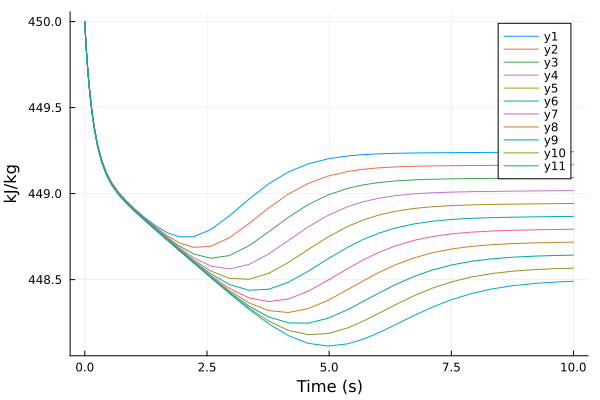

In [81]:
plot_the_res(sol_real)